# Variational quantum eigensolving

Here, we generate a random Hamiltonian and use a simple ansatz to approximate its ground state energy by the Variational Quantum Eigensolver (VQE) method.

## Defining the Hamiltonian

Here, we define a random Hamiltonian with 5 terms acting on 3 qubits:

In [1]:
import numpy as np
from qat.core import Observable, Term

nqbits = 3

np.random.seed(1423543) #fixing seed to have reproducible results
terms = []
for _ in range(5):
    coeff = np.random.random()
    ops = "".join(np.random.choice(["X", "Z"], size=nqbits))
    qbits = np.random.choice(nqbits, size=nqbits, replace=False)
    terms.append(Term(coefficient=coeff, pauli_op=ops, qbits=qbits))
hamiltonian = Observable(nqbits, pauli_terms=terms, constant_coeff=0.0)

print("H:", hamiltonian)

H: 0.5349858976103307 * (ZZZ|[2, 1, 0]) +
0.6223001690189702 * (ZXZ|[0, 1, 2]) +
0.2940544814678502 * (ZXZ|[2, 0, 1]) +
0.37366693739787715 * (XXX|[2, 0, 1]) +
0.3862787171234443 * (XZX|[2, 1, 0])


## Constructing a variational circuit

In the cell below, we construct a variational circuit, with $2 n_\mathrm{qbits}$ parameters $\vec{\theta}$. We choose only $R_y(\theta)$ rotations because we know the ground state to be have only real amplitudes.

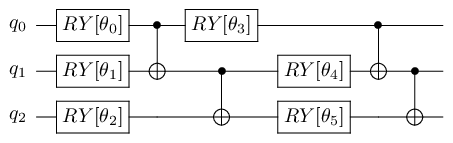

In [2]:
from qat.lang.AQASM import Program, QRoutine, RY, CNOT, RX, Z, H, RZ
prog = Program()
reg = prog.qalloc(nqbits)
theta = [prog.new_var(float, '\\theta_%s'%i)
         for i in range(nqbits * 2)]
for ind in range(nqbits):
    RY(theta[ind])(reg[ind])
for qb in range(nqbits-1):
    CNOT(reg[qb], reg[(qb+1)%nqbits])
for ind in range(nqbits, 2*nqbits):
    RY(theta[ind])(reg[ind - nqbits])
for qb in range(nqbits-1):
    CNOT(reg[qb], reg[(qb+1)%nqbits])
circ = prog.to_circ()
%qatdisplay circ

This ansatz circuit produces an entangled state thanks to the CNOT gates.

## Creating a variational job and a variational stack

We now create a variational job from this circuit and observable.
It is then submitted to a variational stack composed of a perfect QPU, ``LinAlg``, and a variational plugin, ``ScipyMinimizePlugin``. The latter handles parametric jobs. These are jobs whose circuit contains a parameter that is then going to be optimized, using classical optimizers, so as to minimize the value of the observable over the final state.

Below, we are going to test three different classical optimizers: COBYLA, Nelder-Mead, and BFGS.

In [3]:
from qat.qpus import get_default_qpu
from qat.plugins import ScipyMinimizePlugin

job = circ.to_job(job_type="OBS",
                  observable=hamiltonian,
                  nbshots=0)

theta_0 = np.random.random(size=nqbits*2)

linalg_qpu = get_default_qpu()
methods = ["COBYLA", "Nelder-Mead", "BFGS"]
result = {}
for method in methods:
    optimizer_scipy = ScipyMinimizePlugin(method=method,
                                          tol=1e-6,
                                          options={"maxiter": 200},
                                          x0=theta_0)
    qpu = optimizer_scipy | linalg_qpu
    result[method] = qpu.submit(job)

    print("Minimum VQE energy (%s) = %s"%(method, result[method].value))

Minimum VQE energy (COBYLA) = -1.5852036955268782
Minimum VQE energy (Nelder-Mead) = -1.2700915415548988
Minimum VQE energy (BFGS) = -1.5852079319663497


One can check that the final optimized energy is very close to the exact GS energy.

## Plotting the results

Let us now plot the value of the variational energy over the course of the classical optimization. For this, we can retrieve information about the variational job execution in the ``meta_data`` field of the result.

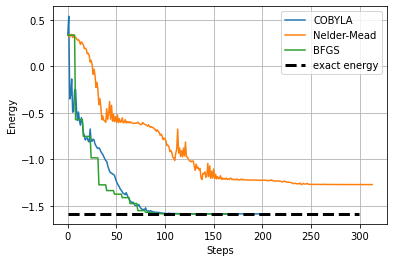

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
for method in methods:
    plt.plot(eval(result[method].meta_data['optimization_trace']),
             label=method)
    
from util import make_matrix
H_mat = make_matrix(hamiltonian)
eigvals = np.linalg.eigvalsh(H_mat)
E0 = min(eigvals)

plt.plot([E0 for _ in range(300)], '--k', lw=3, label="exact energy")
    
plt.grid()
plt.legend(loc="best")
plt.xlabel("Steps")
plt.ylabel("Energy");

We can see that COBYLA converges faster than the other two methods.